In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import json
import os
import pandas as pd
from tqdm import tqdm
import shutil
import sys
root_path = os.path.abspath("..")
data_path = "/data/MHL/bepro/raw"
sys.path.append(root_path)

from preprocess_bepro import load_single_json, create_team_dataframe, create_event_dataframe, create_tracking_dataframe
from visualization import plot_single_frame_positions, plot_window_frame_positions

In [2]:
match_id_lst = os.listdir(data_path)
match_id = match_id_lst[1]

match_path = f"{data_path}/{match_id}"
os.listdir(match_path)

['126285_2_event_data.json',
 '126285_metadata.json',
 '126285_1_frame_data.jsonl',
 '126285_2_frame_data.jsonl',
 '126285_1_event_data.json']

In [3]:
match_id_lst = ["126319", "126325", "126386", "126408", "126444", "126466", "126476", "153390"]
match_id = match_id_lst[0]
match_path = os.path.join(data_path, match_id)
os.listdir(match_path)[0]

'126319_1_event_data.json'

In [ ]:
def rename_files(data_path):
    match_id_lst = os.listdir(data_path)
    for match_id in match_id_lst:
        match_path = os.path.join(data_path, match_id)

        # Check if the current path is a directory.
        if not os.path.isdir(match_path):
            print(f"Skipping: '{match_path}' is not a directory.")
            continue

        print(f"\nProcessing directory: '{match_path}'")

        try:
            files_in_match_dir = os.listdir(match_path)
        except OSError as e:
            print(f"  Error: Could not read files in directory '{match_path}': {e}")
            continue

        found_target_file = False
        for filename in files_in_match_dir:
            if not filename.endswith('json') and not filename.endswith("jsonl"):
                print(f"Remove unnecessary file : {filename}")
                os.remove(f"{match_path}/{filename}")
                continue
            # Find files ending with "_2nd Half.json".
            # Example source filename: '2024-03-02_GwangjuFC vs FCSeoul_2nd Half.json'
            elif filename.endswith("_1st Half.json"):
                old_filepath = os.path.join(match_path, filename)
                
                # Construct the new filename: {match_id}_event_data.json
                new_filename = f"{match_id}_1_event_data.json"
                new_filepath = os.path.join(match_path, new_filename)
            elif filename.endswith("_2nd Half.json"):
                old_filepath = os.path.join(match_path, filename)
                # Construct the new filename: {match_id}_event_data.json
                new_filename = f"{match_id}_2_event_data.json"
                new_filepath = os.path.join(match_path, new_filename)
            else:
                continue
            print(f"  Found target file: '{filename}'")

            # If the current filename is already the new target filename, skip renaming.
            if old_filepath == new_filepath:
                print(f"  Skipped: File '{filename}' is already named as target '{new_filename}'.")
                found_target_file = True
                break # Assume only one such "_2nd Half.json" file per directory.

            # Prevent overwriting if the new filename already exists.
            if os.path.exists(new_filepath):
                print(f"  Warning: Target filename '{new_filepath}' already exists. Skipping rename for '{filename}'.")
            else:
                try:
                    os.rename(old_filepath, new_filepath)
                    print(f"  Renamed: '{filename}' -> '{new_filename}'")
                except OSError as e:
                    print(f"  Error: Failed to rename '{filename}' to '{new_filename}': {e}")
            
            # found_target_file = True
            # Typically, there's only one "_2nd Half.json" file per match.
            # If more are possible and need different handling, remove this break.
            # break 
        
        # if not found_target_file:
        #     print(f"  Info: No file ending with '_2nd Half.json' found in '{match_path}'.")

    print("\nAll operations completed.")
# rename_files(data_path)

In [5]:
# Check Metadata
meta_data_path = f"{match_path}/{match_id}_metadata.json"
meta_data = load_single_json(meta_data_path)
for key, value in meta_data.items():
    print(f"{key} : {value}")

match_id : 126319
match_title : 전북 현대 모터스 vs 광주FC
match_datetime : 2024-04-13T14:00:00+0900
match_full_time : 5400000
match_extra_time : None
periods : [{'period_name': '1st Half', 'period_order': 0, 'period_match_duration': 2700000}, {'period_name': '2nd Half', 'period_order': 1, 'period_match_duration': 2700000}]
home_team : {'team_id': 4640, 'team_name': '전북 현대 모터스', 'team_name_en': 'Jeonbuk Hyundai Motors', 'players': [{'player_id': 354794, 'team_id': 4640, 'shirt_number': '13', 'full_name': '정민기', 'full_name_en': 'Minki Jeong', 'initial_position_name': 'GK', 'is_starting': True}, {'player_id': 354791, 'team_id': 4640, 'shirt_number': '3', 'full_name': '정태욱', 'full_name_en': 'Taewook Jeong', 'initial_position_name': 'CB', 'is_starting': True}, {'player_id': 246402, 'team_id': 4640, 'shirt_number': '4', 'full_name': '박진섭', 'full_name_en': 'Jinseop Park', 'initial_position_name': 'CB', 'is_starting': True}, {'player_id': 491837, 'team_id': 4640, 'shirt_number': '39', 'full_name': '김태

In [6]:
teams_dict = create_team_dataframe(meta_data['home_team'], meta_data['away_team'])
teams_dict['Home']

,player,position,team,jID,pID,tID,xID
0,Minki Jeong,GK,Home,13,354794,4640,0
1,Taewook Jeong,CB,Home,3,354791,4640,1
2,Jinseop Park,CB,Home,4,246402,4640,2
3,Taehwan Kim,RB,Home,39,491837,4640,3
4,Jaeik Lee,LB,Home,14,491834,4640,4
5,Seongung Maeng,CM,Home,28,246403,4640,5
6,Soobin Lee,CM,Home,6,146174,4640,6
7,Yeongjae Lee,RW,Home,8,500430,4640,7
8,Mingyu Song,CAM,Home,10,215818,4640,8
9,Byeonggwan Jeon,LW,Home,33,491835,4640,9


In [7]:
teams_dict['Away']

,player,position,team,jID,pID,tID,xID
0,Jun Lee,GK,Away,21,250099,4648,0
1,Seonggwon Cho,CB,Away,2,345464,4648,1
2,Mingi Lee,LB,Away,3,145701,4648,2
3,Seungwoo Kim,CB,Away,5,250108,4648,3
4,Hyeonseok Doo,RB,Away,13,62386,4648,4
5,Gabriel,RM,Away,11,500135,4648,5
6,Hoyeon Jeong,CM,Away,14,250101,4648,6
7,Taejun Park,CM,Away,55,500142,4648,7
8,Minseo Moon,LM,Away,88,500136,4648,8
9,Joao Victo Magno,CF,Away,9,500134,4648,9


In [8]:
event_df = create_event_dataframe(match_path)
event_df.head()

,period_type,period_name,period_order,period_duration,period_start_time,event_time,team_name,player_shirt_number,player_name,events,x,y,to_x,to_y,attack_direction
0,Half,1st Half,0,2700000,0,2867,Gwangju FC,9,Joao Victo Magno,"[{'event_name': 'Passes', 'property': {'Outcom...",0.4972,0.5136,0.6179,0.5181,LEFT
1,Half,1st Half,0,2700000,0,4333,Gwangju FC,14,Hoyeon Jeong,"[{'event_name': 'Passes Received', 'property':...",0.6179,0.5181,NaN,NaN,LEFT
2,Half,1st Half,0,2700000,0,5600,Gwangju FC,14,Hoyeon Jeong,"[{'event_name': 'Passes', 'property': {'Outcom...",0.6196,0.5214,0.6128,0.7087,LEFT
3,Half,1st Half,0,2700000,0,6867,Gwangju FC,55,Taejun Park,"[{'event_name': 'Passes Received', 'property':...",0.6128,0.7087,NaN,NaN,LEFT
4,Half,1st Half,0,2700000,0,9500,Gwangju FC,55,Taejun Park,"[{'event_name': 'Passes', 'property': {'Outcom...",0.6308,0.7172,0.6984,0.3465,LEFT


In [8]:
match_id = "126466"
match_path = f"{data_path}/{match_id}"

tracking_df = create_tracking_dataframe(match_path, meta_data, teams_dict)
tracking_df.head()

,game_id,period_id,timestamp,frame_id,ball_state,ori_ball_owning_team_id,x,y,z,vx,...,v,ax,ay,az,a,id,team_id,position_name,ball_owning_team_id,is_ball_carrier
0,126466,1,0 days 00:00:01.787000,54,alive,4643,-16.537393,11.5791,0.0,-0.899242,...,1.353721,0.408428,0.669414,0.0,0.784174,145701,None,None,4643,False
1,126466,1,0 days 00:00:01.787000,54,alive,4643,24.386036,-6.5581,0.0,-0.135177,...,0.153991,-0.336498,-0.682146,0.0,0.760628,187313,None,None,4643,False
2,126466,1,0 days 00:00:01.787000,54,alive,4643,-48.231643,0.5986,0.0,0.823666,...,0.841616,0.438605,-0.796352,0.0,0.909148,250079,4648,GK,4643,False
3,126466,1,0 days 00:00:01.787000,54,alive,4643,-5.146714,8.6365,0.0,0.035537,...,0.349532,-0.559315,0.162048,0.0,0.582317,250101,4648,CM,4643,False
4,126466,1,0 days 00:00:01.787000,54,alive,4643,52.399714,-0.1642,0.0,-0.138792,...,0.153709,-0.955754,0.279340,0.0,0.995739,250957,None,None,4643,False


In [22]:
import config as C
from preprocess_bepro import *

teams_df = pd.concat([teams_dict['Home'], teams_dict['Away']], axis=0)
player_lookup = teams_df.set_index('pID')
home_tid = teams_dict['Home']['tID'].iloc[0]
away_tid = teams_dict['Away']['tID'].iloc[0]
player_smoothing_params= C.DEFAULT_PLAYER_SMOOTHING_PARAMS
ball_smoothing_params= C.DEFAULT_BALL_SMOOTHING_PARAMS
max_player_speed=  C.MAX_PLAYER_SPEED
max_player_acceleration=  C.MAX_PLAYER_ACCELERATION
max_ball_speed=  C.MAX_BALL_SPEED
max_ball_acceleration=  C.MAX_BALL_ACCELERATION

match_id = match_path.split("/")[-1]
first_half_tracking_data = load_jsonl(f"{match_path}/{match_id}_1_frame_data.jsonl")
second_half_tracking_data = load_jsonl(f"{match_path}/{match_id}_2_frame_data.jsonl")

all_object_rows = []


In [23]:
for half_tracking_data in [first_half_tracking_data, second_half_tracking_data]:
    for frame_data in half_tracking_data:
        # Check ball state
        ball_state = frame_data.get('ball_state')
        if ball_state is None or ball_state == 'out':
            new_ball_state = 'dead'
            ball_owning_team_id = None
        else:
            new_ball_state = 'alive'
            if ball_state == 'home':
                ball_owning_team_id = home_tid
            elif ball_state == 'away':
                ball_owning_team_id = away_tid
            else:
                ball_owning_team_id = ball_state

        # 2. Extract current frames base information.
        frame_info = {
            'game_id': match_id,
            'period_id': frame_data.get('period_order') + 1,
            'timestamp': frame_data.get('match_time'),
            'frame_id': frame_data.get('frame_index'),
            'ball_state': new_ball_state,
            'ball_owning_team_id': ball_owning_team_id,
        }

        for object in ['players', 'balls']:
            object_list = frame_data.get(object, [])
            if object_list:
                for object_data in object_list:
                    row_data = frame_info.copy()
                    row_data.update(object_data)
                    if object == 'balls':
                        row_data['id'] = 'ball'
                        row_data['team_id'] = 'ball'
                        row_data['position_name'] = 'ball'
                    else:
                        # row_data['id'] = str(row_data['player_id'])
                        # teams_df['team_id'] = teams_df[teams_df['pID'] == row_data['id']]['position'].iloc[0]
                        # teams_df['position_name'] = teams_df[teams_df['pID'] == row_data['id']]['tID'].iloc[0]
                        player_pID = str(object_data.get('player_id'))
                        row_data['id'] = player_pID
                        if player_pID in player_lookup.index:
                            row_data['team_id'] = player_lookup.loc[player_pID, 'tID'] if 'tID' in player_lookup.columns else None
                            row_data['position_name'] = player_lookup.loc[player_pID, 'position'] if 'position' in player_lookup.columns else None
                        else:
                            row_data['team_id'] = None
                            row_data['position_name'] = None
                    row_data.pop('object')
                    row_data.pop('player_id')
                    all_object_rows.append(row_data)


In [24]:
tracking_df = pd.DataFrame(all_object_rows)
tracking_df['timestamp'] = pd.to_timedelta(tracking_df['timestamp'], unit='ms')

In [25]:
tracking_df['x'].max(), tracking_df['x'].min(), tracking_df['y'].max(), tracking_df['y'].min()

(110.25, -6.8316, 74.6005, -3.8714)

In [26]:
tracking_df = rescale_pitch(tracking_df, meta_data)
tracking_df['x'].max(), tracking_df['x'].min(), tracking_df['y'].max(), tracking_df['y'].min()

(57.75, -59.3316, 40.6005, -37.8714)

In [36]:
total_resampled_df['x'].max(), total_resampled_df['x'].min(), total_resampled_df['y'].max(), total_resampled_df['y'].min()

(57.75, -59.3316, 40.6005, -37.8714)

In [35]:
target_hz = 25
resample_freq_ms = int(1000 / target_hz)
resample_freq_str = f'{resample_freq_ms}ms'

period_list = []
for period_id in tracking_df['period_id'].unique():
    period_df = tracking_df[tracking_df['period_id'] == period_id]

    min_timestamp = period_df['timestamp'].min()
    max_timestamp = period_df['timestamp'].max()
    global_original_index = pd.to_timedelta(sorted(period_df['timestamp'].unique()))
    global_target_index = pd.timedelta_range(start=min_timestamp, end=max_timestamp, freq=resample_freq_str)

    grouped = period_df.groupby('id')
    resampled_list = []

    for agent_id, agent_group in grouped:
        group_df = agent_group.copy().set_index('timestamp')
        if group_df.index.has_duplicates:
            group_df = group_df.loc[~group_df.index.duplicated(keep='first')] # Some data contains duplicated coordinates for each players in the same frame.

        union_index = global_original_index.union(global_target_index)
        reindexed_group = group_df.reindex(union_index)

        # Interpolation
        interpolation_cols = ['x', 'y', 'speed']
        reindexed_group[interpolation_cols] = reindexed_group[interpolation_cols].interpolate(method='pchip', limit_area='inside')
        
        # 5. 최종 결과 필터링: 보간된 결과에서 25Hz 시간대의 데이터만 선택
        final_group = reindexed_group.reindex(global_target_index)

        # 6. 범주형 데이터 채우기
        final_group['id'] = agent_id
        ffill_cols = [col for col in group_df.columns if col not in interpolation_cols and col != 'id']
        final_group[ffill_cols] = final_group[ffill_cols].ffill()
        final_group = final_group.dropna(subset=['x', 'y'])
        resampled_list.append(final_group)

    period_list += resampled_list

total_resampled_df = pd.concat(period_list).reset_index().rename(columns={'index': 'timestamp'})
total_resampled_df['frame_id'] = (total_resampled_df['timestamp'].astype(np.int64) // (10**9 / target_hz)).astype(int)
total_resampled_df = total_resampled_df.sort_values(['game_id', 'timestamp', 'period_id', 'frame_id', 'id'])


In [21]:
tracking_df = resample_tracking_dataframe(tracking_df, target_hz=25)
tracking_df['x'].max(), tracking_df['x'].min(), tracking_df['y'].max(), tracking_df['y'].min()

(4186.473395503848, -5070.53552830169, 5777.942462343876, -5057.5900035438935)

In [42]:
tracking_df[
    (tracking_df['period_id'] == 1) &
    (tracking_df['timestamp'] >= pd.to_timedelta('0 days 00:00:00')) &
    (tracking_df['timestamp'] <= pd.to_timedelta('0 days 00:00:03')) &
    (tracking_df['id'] == 'ball')
    ]

,game_id,period_id,timestamp,frame_id,ball_state,ball_owning_team_id,x,y,speed,id,team_id,position_name
1908,126319,1,0 days 00:00:02.866000,86,dead,None,-0.2982,0.9267,NaN,ball,ball,ball
1931,126319,1,0 days 00:00:02.900000,87,alive,4648,-0.0034,0.9338,NaN,ball,ball,ball
1954,126319,1,0 days 00:00:02.933000,88,alive,4648,0.2915,0.9409,NaN,ball,ball,ball
1977,126319,1,0 days 00:00:02.966000,89,alive,4648,0.5863,0.9481,NaN,ball,ball,ball
2000,126319,1,0 days 00:00:03,90,alive,4648,0.8812,0.9552,NaN,ball,ball,ball


In [ ]:
tracking_df[tracking_df['timestamp'] == pd.Timedelta()]

In [47]:
import os
import tarfile
from pathlib import Path

def archive_dynamic_files(root_dir, file_suffix, output_tar_name):
    """
    지정된 루트 디렉토리의 각 하위 폴더에서, 폴더 이름(match_id)을 포함하는
    특정 파일을 찾아 하나의 zip 파일로 압축합니다.

    Args:
        root_dir (str): 'match_id' 폴더들이 있는 최상위 경로.
        file_suffix (str): 찾을 파일 이름의 접미사 (예: '_processed_dict.pkl').
        output_zip_name (str): 생성할 zip 파일의 이름.
    """
    root_path = Path(root_dir)
    if not root_path.is_dir():
        print(f"❌ 에러: 경로를 찾을 수 없습니다 -> '{root_dir}'")
        return

    # 1. 압축할 파일 목록 찾기
    # '*' 와일드카드를 사용하여 동적인 파일 이름을 검색합니다.
    # "*/" : 모든 하위 폴더(match_id)
    # "*"+file_suffix : 해당 접미사로 끝나는 모든 파일
    file_pattern = f"*{file_suffix}"
    files_to_archive = sorted(list(root_path.glob(f"*/{file_pattern}")))

    if not files_to_archive:
        print(f"❌ 에러: '{file_pattern}' 패턴의 파일을 찾을 수 없습니다. 경로와 파일 이름을 확인해주세요.")
        return

    print(f"🗂️ 총 {len(files_to_archive)}개의 일치하는 파일을 찾았습니다.")
    print(f"압축을 시작합니다... -> '{output_tar_name}'")
    # 2. Zip 파일 생성 및 파일 추가
    try: 
        with tarfile.open(output_tar_name, 'w:gz') as tarf:
            for file_path in files_to_archive:
                # zip 파일 내에 저장될 경로와 이름 (e.g., "match_id_1/match_id_1_processed_dict.pkl")
                arcname = file_path.relative_to(root_path)
                tarf.add(file_path, arcname=arcname)
                print(f"  -> 추가 중: {arcname}")
                
        print(f"\n✅ 압축 완료! 현재 위치에 '{output_tar_name}' 파일이 생성되었습니다.")

    except Exception as e:
        print(f"\n❌ 압축 중 에러가 발생했습니다: {e}")



# --- 설정 ---
# 1. 'processed' 폴더가 있는 경로
ROOT_DIRECTORY = "/data/MHL/bepro/processed/"

# 2. 찾아내서 압축할 파일 이름의 '고정된 뒷부분'
#    예: 12345_processed_dict.pkl, 67890_processed_dict.pkl 등
TARGET_FILE_SUFFIX = "_processed_dict.pkl"

# 3. 최종적으로 생성될 압축 파일 이름
OUTPUT_ZIP_FILE = "all_processed_dicts.tar.gz"

# 함수 실행
archive_dynamic_files(ROOT_DIRECTORY, TARGET_FILE_SUFFIX, OUTPUT_ZIP_FILE)

🗂️ 총 40개의 일치하는 파일을 찾았습니다.
압축을 시작합니다... -> 'all_processed_dicts.tar.gz'


  -> 추가 중: 126285/126285_processed_dict.pkl
  -> 추가 중: 126293/126293_processed_dict.pkl
  -> 추가 중: 126298/126298_processed_dict.pkl
  -> 추가 중: 126306/126306_processed_dict.pkl
  -> 추가 중: 126309/126309_processed_dict.pkl
  -> 추가 중: 126315/126315_processed_dict.pkl
  -> 추가 중: 126319/126319_processed_dict.pkl
  -> 추가 중: 126325/126325_processed_dict.pkl
  -> 추가 중: 126332/126332_processed_dict.pkl
  -> 추가 중: 126341/126341_processed_dict.pkl
  -> 추가 중: 126348/126348_processed_dict.pkl
  -> 추가 중: 126350/126350_processed_dict.pkl
  -> 추가 중: 126356/126356_processed_dict.pkl
  -> 추가 중: 126364/126364_processed_dict.pkl
  -> 추가 중: 126367/126367_processed_dict.pkl
  -> 추가 중: 126378/126378_processed_dict.pkl
  -> 추가 중: 126380/126380_processed_dict.pkl
  -> 추가 중: 126386/126386_processed_dict.pkl
  -> 추가 중: 126391/126391_processed_dict.pkl
  -> 추가 중: 126401/126401_processed_dict.pkl
  -> 추가 중: 126408/126408_processed_dict.pkl
  -> 추가 중: 126411/126411_processed_dict.pkl
  -> 추가 중: 126418/126418_process

In [ ]:
tracking_df.isna().sum()

game_id                          0
period_id                        0
timestamp                        0
frame_id                         0
ball_state                       0
ori_ball_owning_team_id          0
x                                0
y                                0
z                                0
vx                               0
vy                               0
vz                               0
v                                0
ax                               0
ay                               0
az                               0
a                                0
id                               0
team_id                    1435471
position_name              1534597
ball_owning_team_id              0
is_ball_carrier                  0
dtype: int64

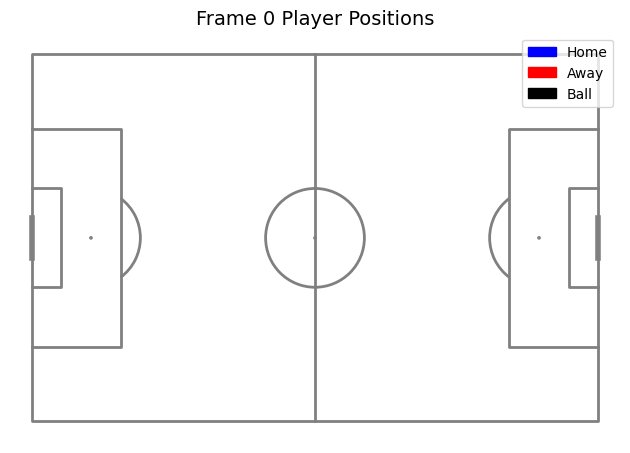

In [10]:
plot_single_frame_positions(tracking_df, period_id=1, frame_idx=0, home_team_info=teams_dict['Home'], away_team_info=teams_dict['Away'])

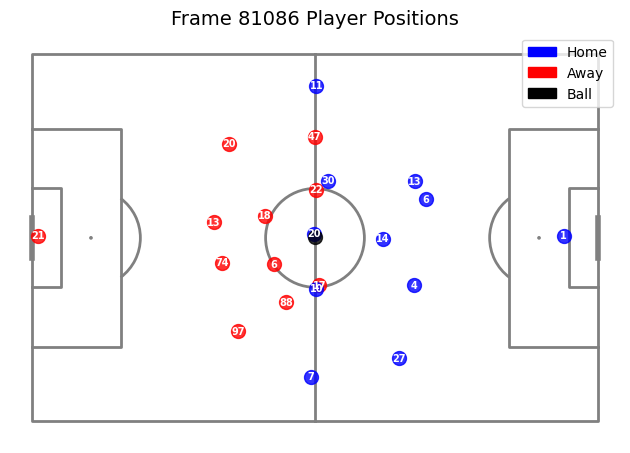

In [10]:
plot_single_frame_positions(tracking_df, period_id=2, frame_idx=tracking_df[tracking_df['period_id']==2]['frame_id'].min(), home_team_info=teams_dict['Home'], away_team_info=teams_dict['Away'])

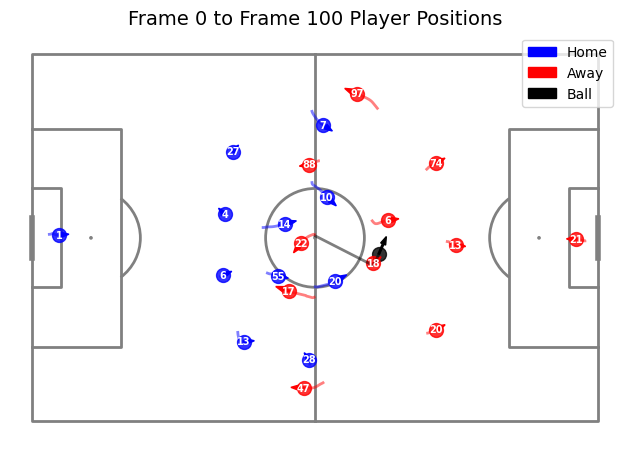

In [11]:
plot_window_frame_positions(tracking_df, period_id=1, start_frame_idx=0, end_frame_idx = 100, home_team_info=teams_dict['Home'], away_team_info=teams_dict['Away'])

In [ ]:
import polars as pl
from unravel.soccer import KloppyPolarsDataset
from dataclasses import dataclass
from typing import Union, Any, Dict
import config as C

@dataclass
class DefaultSettings:
    home_team_id: Union[str, int]
    away_team_id: Union[str, int]
    max_player_speed: float = 12.0
    max_ball_speed: float = 28.0
    max_player_acceleration: float = 6.0
    max_ball_acceleration: float = 13.5
    ball_carrier_threshold: float = 25.0

settings = DefaultSettings(
            home_team_id=teams_dict['Home']['tID'].iloc[0],
            away_team_id=teams_dict['Away']['tID'].iloc[0],
            max_player_speed=C.MAX_PLAYER_SPEED,
            max_ball_speed=C.MAX_BALL_SPEED,
            max_player_acceleration=C.MAX_PLAYER_ACCELERATION,
            max_ball_acceleration=C.MAX_BALL_ACCELERATION,
            ball_carrier_threshold=C.BALL_CARRIER_THRESHOLD,
        )

class PressingIntensityDataset(KloppyPolarsDataset):
    def __init__(self, tracking_df, settings):
        self.data = pl.from_pandas(tracking_df)
        self.settings = settings

dataset = PressingIntensityDataset(tracking_df, settings)

2025-05-24 07:30:52.981762: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-24 07:30:52.984569: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-24 07:30:53.012733: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-24 07:30:53.012784: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-24 07:30:53.012815: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [ ]:
from pressing_intensity import CustomPressingIntensity

model = CustomPressingIntensity(dataset=dataset)
model.fit(
    method="teams",
    ball_method="max",
    orient="home_away",
    speed_threshold=2.0,
)

*****Custom Fit*****
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78


1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
1 100
1 101
1 102
1 103
1 104
1 105
1 106
1 107
1 108
1 109
1 110
1 111
1 112
1 113
1 114
1 115
1 116
1 117
1 118
1 119
1 120
1 121
1 122
1 123
1 124
1 125
1 126
1 127
1 128
1 129
1 130
1 131
1 132
1 133
1 134
1 135
1 136
1 137
1 138
1 139
1 140
1 141
1 142
1 143
1 144
1 145
1 146
1 147
1 148
1 149
1 150
1 151
1 152
1 153
1 154
1 155
1 156
1 157
1 158
1 159
1 160
1 161
1 162
1 163
1 164
1 165
1 166
1 167
1 168
1 169
1 170
1 171
1 172
1 173
1 174
1 175
1 176
1 177
1 178
1 179
1 180
1 181
1 182
1 183
1 184
1 185
1 186
1 187
1 188
1 189
1 190
1 191
1 192
1 193
1 194
1 195
1 196
1 197
1 198
1 199
1 200
1 201
1 202
1 203
1 204
1 205
1 206
1 207
1 208
1 209
1 210
1 211
1 212
1 213
1 214
1 215
1 216
1 217
1 218
1 219
1 220
1 221
1 222
1 223
1 224
1 225
1 226
1 227
1 228
1 229
1 230
1 231
1 232
1 233
1 234
1 235
1 236
1 237
1 238
1 239
1 240
1 241
1 242
1 243
1 244
1 245
1 246
1 247
1 248
1

PressingIntensity(n_frames=120493)